In [51]:
# Bibliotecas necessárias para o experimento

import numpy as np, numpy.random
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from random import randint, uniform, random
from scipy.linalg import sqrtm

In [52]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 200
 # 115, 150

In [53]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [54]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [55]:
def lind(u, Ut, Uf, t, lbda):
    n = 1
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    if t == 0:
        fx = u[0]
        fy = u[1]
        fz = u[2]
        F=np.dot(u[0],Ax)+np.dot(u[1],Ay)+np.dot(u[2],Az)+B
    else:
        fx=field(Ut, Uf, u[0], 0.35, Ax, B)
        fy=field(Ut, Uf, u[1], 0.31, Ay, B)
        fz=field(Ut, Uf, u[2], 0.34, Az, B)
        P=400

        if abs(fx) > P:
            if fx < 0:
                fx = -P
            else:
                fx = P
        if abs(fy) > P:
            if fy < 0:
                fy = -P
            else:
                fy = P
        if abs(fz) > P:
            if fz < 0:
                fz = -P
            else:
                fz = P

        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [56]:
def rungeKutta(u, Ut, Uf, h, t, lbda):

    if t == 0:
        
        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    else:

        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [57]:
def func_objetivo(u, Ut, Uf, h, tempo, lbda):
    a, b, c, Ut1 = rungeKutta(u, Ut, Uf, h, tempo, lbda)
    return (np.linalg.norm(Ut1-Uf))**2

In [58]:
def gerar_populacao():
    populacao = np.zeros((TAMANHO_POP,3))
    for individuo in range(TAMANHO_POP):
        for genes in range(3):
            populacao[individuo,genes] = uniform(MIN, MAX)
    return populacao

In [59]:
def calcular_func(populacao, Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    valor_func = np.zeros(TAMANHO_POP)
    for individuo in range(TAMANHO_POP):
        valor_func[individuo] = func_objetivo(populacao[individuo,:], Ut, Uf, h, tempo, lbda)
    return valor_func

In [60]:
def selecao(valor_fitness):
    pos = np.random.choice(range(TAMANHO_POP), 2, replace=False)
    valor = valor_fitness[pos[0]] < valor_fitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [61]:
def divisao_fitness(valor_funcao_objetivo):
    divisao = 0
    for i in range(len(valor_funcao_objetivo)):
        divisao += valor_funcao_objetivo[i]
    return divisao

def fitness(valor_funca_objetivo):
    return valor_funca_objetivo/divisao_fitness(valor_funca_objetivo)

In [62]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [63]:
def mutacao(individuo, horizonte):
    
    # Gaussian function
    for i in range (0, horizonte):
        if random() < TAXA_MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(MIN, MAX)-2)**2))
    
    return individuo

In [64]:
def genetico(Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    
    horizonte = 3
    pop = gerar_populacao()
    fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])

        pop = new_pop
        fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
                
    return pop[pos_min_fo,:][0,0]

In [65]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [66]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [67]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [68]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [ ]:
def main():
    contador = 0
    r = 1
    w = 1
    aas = []
    u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard
    
    Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard
    
    r0 = [[1], [0], [0]]
    rf = np.dot(Uf, r0)
    pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
    
    h=0.001
    t=0
    i=0
    lbda=0.01
    # Proposta do algoritmo genético
    resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
    u[0] = resultado_algoritmo_genetico[0]
    u[1] = resultado_algoritmo_genetico[1]
    u[2] = resultado_algoritmo_genetico[2]
    aas.append((u[0],u[1],u[2]))
    distance_vector = []
    fx_vector = []
    fy_vector = []
    fz_vector = []
    rho_vector = np.zeros((4,1000),dtype=np.complex128)
    fid_vector = []
    fid_autores = []
       
    while t < 100:

        if contador == 0:
            a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
            D = np.linalg.norm(Uto-Uf)**2
            distance_vector.append(D)
            fx_vector.append(a)
            fy_vector.append(b)
            fz_vector.append(c)
            rt = np.dot(Uto, r0)
            pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
            rho_vector[0][w] = pt[0][0]
            rho_vector[1][w] = pt[0][1]
            rho_vector[2][w] = pt[1][0]
            rho_vector[3][w] = pt[1][1]
            fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
            fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            aas.append((u[0],u[1],u[2]))
            t += 1
            w += 1
        else:
            h = 0.0001
            a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
            D = np.linalg.norm(Uto-Uf)**2
            distance_vector.append(D)
            fx_vector.append(a)
            fy_vector.append(b)
            fz_vector.append(c)
            rt = np.dot(Uto, r0)
            pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
            rho_vector[0][w] = pt[0][0]
            rho_vector[1][w] = pt[0][1]
            rho_vector[2][w] = pt[1][0]
            rho_vector[3][w] = pt[1][1]
            fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
            fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
            t += 0.1
            w += 1
        if  (1/2*(1+rt[2][0]) > 1 or fid_autores[-1] > 1 or fid_vector[-1] > 1):
            contador = 2
            distance_vector[-1] = distance_vector[-2]
            rho_vector[0][w] = rho_vector[0][w-1]
            rho_vector[1][w] = rho_vector[1][w-1]
            rho_vector[2][w] = rho_vector[2][w-1]
            rho_vector[3][w] = rho_vector[3][w  -1]
            fid_vector[-1] = fid_vector[-2]
            fid_autores[-1] = fid_autores[-2]
        
            
        
        print(f"Distância: {distance_vector[-1]}")
        print(f"Fidelidade: {fid_vector[-1]}")
        print(f"Fidelidade da porta: {fid_autores[-1]}")
        Ut = Uto
        

    print(f"O rho gerado foi: {pt}") 
    print(f"A matriz de evolução Ut gerada foi: {Ut}")
    print(f"Portanto, a distância gerada foi: {D}")
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
    
    #leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
    #densidade(rho_vector,t,lbda)
    #fidelidade(fid_vector,t,lbda)
    #fidelidade(fid_autores,t,lbda)
    #distance(distance_vector,t,lbda)

    return fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, aas

In [70]:
import matplotlib.pyplot as plt

def histograma(componente, valores_as):

    valores = []
    # Extração dos valores para o componente escolhido
    valores_intermediarios = [sublista for sublista in a]
    for i in valores_intermediarios:
        valores.append(i[componente])
    
    # Criação do histograma
    plt.hist(valores, bins=10, edgecolor='black')
    plt.xlabel(f'Componente {["x", "y", "z"][componente]}')
    plt.ylabel('Frequência')
    plt.title(f'Histograma do Componente {["x", "y", "z"][componente]}')
    plt.show()


Começará a função principal
Distância: 7.909911713494694
Fidelidade: (0.5057609206906669-2.107439527219152e-07j)
Fidelidade da porta: 0.32599474763885056
Distância: 6.848268556487703
Fidelidade: (0.5731860528379378-0.0003105464668245617j)
Fidelidade da porta: 0.26494113165461564
Distância: 4.9008935902697
Fidelidade: (0.6944073131498978-4.013140047265311e-05j)
Fidelidade da porta: 0.2749106765234656
Distância: 2.673624767606841
Fidelidade: (0.8330599988310751-0.00020629053565502834j)
Fidelidade da porta: 0.4798633810430401
Distância: 0.862315105160598
Fidelidade: (0.9460811092154356-8.618993907017767e-05j)
Fidelidade da porta: 0.7987403676798066
Distância: 0.19202624030980603
Fidelidade: (0.9900091642574044+0.00012159643724184004j)
Fidelidade da porta: 0.9543854181922905
Distância: 0.050380958486949734
Fidelidade: (0.9978019950083242-2.0177707419617206e-05j)
Fidelidade da porta: 0.9894750655438491
Distância: 0.014401988771856502
Fidelidade: (0.9996296407173265-3.596038784492555e-07j)
F

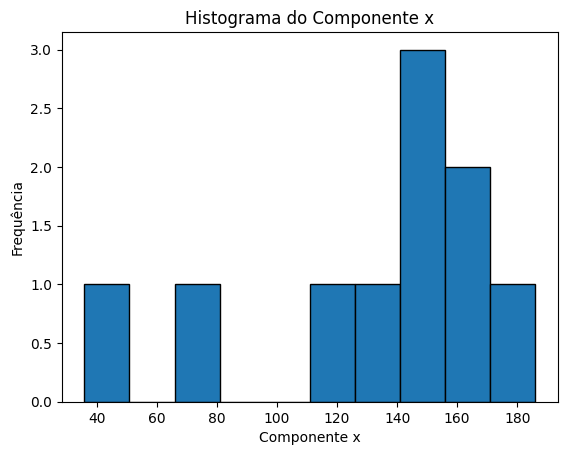

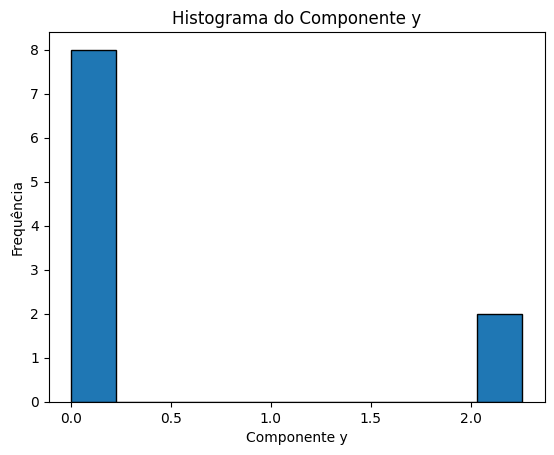

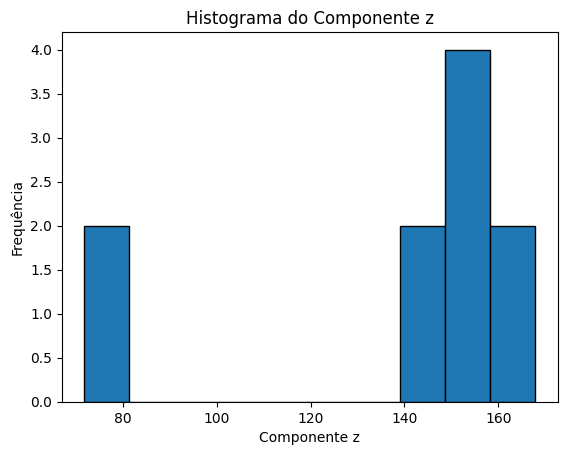

Terminou o histograma
Valores de média na iteração 1:
Portas: 0.999750739227795
Estados: (0.9994885619525269+1.1894729091192515e-07j)
Distância: 4.8767259939254226e-05
 


In [71]:
portas = []
estados = []
distancia = []
i = 1

print(f"Começará a função principal")
fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, a = main()
print(f"Terminou a função principal")
print(f"Veja o log: (Dos estados)")
print(fid_vector)
print(f"Veja o log: (Das portas)")
print(fid_autores)

portas.append(fid_autores[-1])
estados.append(fid_vector[-1])
distancia.append(distance_vector[-1])

print(f"Começou o histograma")
histograma(0, a)
histograma(1, a)
histograma(2, a)
print(f"Terminou o histograma")

print(f"Valores de média na iteração {i}:")
print(f"Portas: {sum(portas)/i}")
print(f"Estados: {sum(estados)/i}")
print(f"Distância: {sum(distancia)/i}")
print(" ")

In [72]:
fid_vector

[(0.5057609206906669701-2.1074395272191519658e-07j),
 (0.57318605283793774315-0.00031054646682456169488j),
 (0.69440731314989783513-4.013140047265311113e-05j),
 (0.8330599988310750895-0.00020629053565502833496j),
 (0.94608110921543562123-8.61899390701776671e-05j),
 (0.9900091642574043752+0.00012159643724184004643j),
 (0.9978019950083242753-2.0177707419617205736e-05j),
 (0.9996296407173264939-3.596038784492555007e-07j),
 (0.9996296407173264939-3.596038784492555007e-07j),
 (0.9996296407173264939-3.596038784492555007e-07j),
 (0.9996296407173264939-3.596038784492555007e-07j),
 (0.9996296407173264939-3.596038784492555007e-07j),
 (0.9996296407173264939-3.596038784492555007e-07j),
 (0.9996296407173264939-3.596038784492555007e-07j),
 (0.9996296407173264939-3.596038784492555007e-07j),
 (0.9996296407173264939-3.596038784492555007e-07j),
 (0.9996296407173264939-3.596038784492555007e-07j),
 (0.9996296407173264939-3.596038784492555007e-07j),
 (0.9996296407173264939-3.596038784492555007e-07j),
 (0.9

In [73]:
fid_autores

[0.32599474763885056,
 0.26494113165461564,
 0.2749106765234656,
 0.4798633810430401,
 0.7987403676798066,
 0.9543854181922905,
 0.9894750655438491,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.9984673259879381,
 0.99846732

In [74]:
rho_vector

array([[0.        +0.j        , 0.50561644+0.j        ,
        0.57317527+0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.49394811-0.07732109j,
        0.42664819-0.25010595j, ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.49394811+0.07732109j,
        0.42664819+0.25010595j, ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.49438356+0.j        ,
        0.42682473+0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ]])

In [75]:
distance_vector

[7.909911713494694,
 6.848268556487703,
 4.9008935902697,
 2.673624767606841,
 0.862315105160598,
 0.19202624030980603,
 0.050380958486949734,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014401988771856502,
 0.014

In [76]:
fx_vector

[144.7267616127808,
 400,
 400,
 400,
 388.7094240317735,
 149.59301818523141,
 64.55130051389003,
 32.1902720452756,
 16.9926623197531,
 13.531646463234233,
 12.931403148048052,
 12.358058890191067,
 11.810363647892869,
 11.287132416653291,
 10.78724080990568,
 10.309621077895457,
 9.853258507147443,
 9.417188151497204,
 9.000491852918065,
 8.60229551650086,
 8.221766609119161,
 7.858111855688538,
 7.510575110631662,
 7.178435385297413,
 6.86100501474104,
 6.557627949528711,
 6.267678160146208,
 5.990558143221632,
 5.725697520159674,
 5.472551719968445,
 5.230600739070311,
 4.999347971752364,
 4.778319105652673,
 4.567061077314019,
 4.365141083383656,
 4.17214564350897,
 3.9876797113863103,
 3.8113658307732226,
 3.6428433335810766,
 3.481767577432218,
 3.3278092202995375,
 3.1806535300511456,
 3.0399997269031798,
 2.905560356943044,
 2.7770606950264667,
 2.654238175477423,
 2.536841849132041,
 2.4246318653682515,
 2.317378977853379,
 2.2148640728236906,
 2.116877718784019,
 2.02321973

In [77]:
fy_vector

[3.816700505123493e-07,
 -0.08010657334530115,
 3.5779840376665812,
 1.7231331187908794,
 0.028522729940147745,
 -0.01586575461478426,
 -0.005656133839355023,
 -0.0010358870296282529,
 0.0005063389456287063,
 0.0004591740284653519,
 0.0005389989445783201,
 0.0006103606065348632,
 0.000674135074928198,
 0.0007311103765429407,
 0.000781994508921998,
 0.0008274229268982405,
 0.0008679654918701824,
 0.000904132881848065,
 0.0009363824728719386,
 0.0009651237112741914,
 0.0009907230022101646,
 0.0010135081435872157,
 0.0010337723365151888,
 0.0010517778041119446,
 0.0010677590502689634,
 0.0010819257890974357,
 0.0010944655744191318,
 0.0011055461570352403,
 0.0011153175956893418,
 0.0011239141457605763,
 0.0011314559478148507,
 0.00113805053629116,
 0.0011437941867999844,
 0.0011487731188192592,
 0.0011530645689755762,
 0.001156737748620775,
 0.00115985469804693,
 0.0011624710484315578,
 0.0011646367014600393,
 0.0011663964355340588,
 0.0011677904465363668,
 0.0011688548302707386,
 0.00116

In [78]:
fz_vector

[155.81821434512474,
 400,
 400,
 400,
 400,
 143.75402105930664,
 73.52410518024429,
 38.62709317825147,
 20.57105986444142,
 21.486819602989684,
 20.081987719822642,
 18.76951819599489,
 17.543243948307268,
 16.397426221451234,
 15.326721987372956,
 14.326154301862378,
 13.391085276582334,
 12.517191374002886,
 11.700440773797098,
 10.937072593641691,
 10.223577776234373,
 9.556681478654607,
 8.933326820744705,
 8.350659866618459,
 7.806015728243669,
 7.296905692726521,
 6.821005285806375,
 6.376143193443152,
 5.960290971487703,
 5.571553480469118,
 5.208159988677131,
 4.868455892100216,
 4.550895004514722,
 4.254032375202739,
 3.976517595485585,
 3.7170885585623394,
 3.4745656400944585,
 3.247846269625072,
 3.035899865304584,
 2.8377631065462134,
 2.6525355211844053,
 2.4793753654799833,
 2.3174957769289177,
 2.166161181304726,
 2.02468393671274,
 1.8924211986712265,
 1.7687719913710405,
 1.6531744713120187,
 1.545103370479663,
 1.444067607117328,
 1.3496080529740615,
 1.26129544667

In [79]:
a

[(144.7267616127808, 3.816700505123493e-07, 155.81821434512474),
 (154.46390621450172, 0.00014110804384072736, 145.08362680181565),
 (35.78076625168923, 2.2579826056518613, 71.77306226739847),
 (66.28275177660564, 2.1288837849830107, 76.30401398621133),
 (157.8506416963774, 0.009410978807373006, 156.26899306953544),
 (186.00567415730035, 0.001169725473850154, 146.66795613352141),
 (167.79652014482548, 1.341521234757832e-05, 156.59113855886986),
 (153.26962455010778, 0.0001884472619280358, 156.7112584097436),
 (140.32676509706295, 0.00016795008198057927, 158.8428238221359),
 (113.05570973010256, 3.7074185672477086e-05, 167.8767154948028)]